<a target="_blank" href="https://colab.research.google.com/github/mrdbourke/simple-local-rag/blob/main/00-simple-local-rag.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Create and run a local RAG pipeline from scratch

The goal of this notebook is to build a RAG (Retrieval Augmented Generation) pipeline from scratch and have it run on a local GPU.

Specifically, we'd like to be able to open a PDF file, ask questions (queries) of it and have them answered by a Large Language Model (LLM).

There are frameworks that replicate this kind of workflow, including [LlamaIndex](https://www.llamaindex.ai/) and [LangChain](https://www.langchain.com/), however, the goal of building from scratch is to be able to inspect and customize all the parts.

## What is RAG?

RAG stands for Retrieval Augmented Generation.

It was introduced in the paper [*Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks*](https://arxiv.org/abs/2005.11401).

Each step can be roughly broken down to:

* **Retrieval** - Seeking relevant information from a source given a query. For example, getting relevant passages of Wikipedia text from a database given a question.
* **Augmented** - Using the relevant retrieved information to modify an input to a generative model (e.g. an LLM).
* **Generation** - Generating an output given an input. For example, in the case of an LLM, generating a passage of text given an input prompt.

## Why RAG?

The main goal of RAG is to improve the generation outptus of LLMs.

Two primary improvements can be seen as:
1. **Preventing hallucinations** - LLMs are incredible but they are prone to potential hallucination, as in, generating something that *looks* correct but isn't. RAG pipelines can help LLMs generate more factual outputs by providing them with factual (retrieved) inputs. And even if the generated answer from a RAG pipeline doesn't seem correct, because of retrieval, you also have access to the sources where it came from.
2. **Work with custom data** - Many base LLMs are trained with internet-scale text data. This means they have a great ability to model language, however, they often lack specific knowledge. RAG systems can provide LLMs with domain-specific data such as medical information or company documentation and thus customized their outputs to suit specific use cases.

The authors of the original RAG paper mentioned above outlined these two points in their discussion.

> This work offers several positive societal benefits over previous work: the fact that it is more
strongly grounded in real factual knowledge (in this case Wikipedia) makes it “hallucinate” less
with generations that are more factual, and offers more control and interpretability. RAG could be
employed in a wide variety of scenarios with direct benefit to society, for example by endowing it
with a medical index and asking it open-domain questions on that topic, or by helping people be more
effective at their jobs.

RAG can also be a much quicker solution to implement than fine-tuning an LLM on specific data.



## What kind of problems can RAG be used for?

RAG can help anywhere there is a specific set of information that an LLM may not have in its training data (e.g. anything not publicly accessible on the internet).

For example you could use RAG for:
* **Customer support Q&A chat** - By treating your existing customer support documentation as a resource, when a customer asks a question, you could have a system retrieve relevant documentation snippets and then have an LLM craft those snippets into an answer. Think of this as a "chatbot for your documentation". Klarna, a large financial company, [uses a system like this](https://www.klarna.com/international/press/klarna-ai-assistant-handles-two-thirds-of-customer-service-chats-in-its-first-month/) to save $40M per year on customer support costs.
* **Email chain analysis** - Let's say you're an insurance company with long threads of emails between customers and insurance agents. Instead of searching through each individual email, you could retrieve relevant passages and have an LLM create strucutred outputs of insurance claims.
* **Company internal documentation chat** - If you've worked at a large company, you know how hard it can be to get an answer sometimes. Why not let a RAG system index your company information and have an LLM answer questions you may have? The benefit of RAG is that you will have references to resources to learn more if the LLM answer doesn't suffice.
* **Textbook Q&A** - Let's say you're studying for your exams and constantly flicking through a large textbook looking for answers to your quesitons. RAG can help provide answers as well as references to learn more.

All of these have the common theme of retrieving relevant resources and then presenting them in an understandable way using an LLM.

From this angle, you can consider an LLM a calculator for words.


## Why local?

Privacy, speed, cost.

Running locally means you use your own hardware.

From a privacy standpoint, this means you don't have send potentially sensitive data to an API.

From a speed standpoint, it means you won't necessarily have to wait for an API queue or downtime, if your hardware is running, the pipeline can run.

And from a cost standpoint, running on your own hardware often has a heavier starting cost but little to no costs after that.

Performance wise, LLM APIs may still perform better than an open-source model running locally on general tasks but there are more and more examples appearing of smaller, focused models outperforming larger models.


## Key terms

| Term | Description |
| ----- | ----- |
| **Token** | A sub-word piece of text. For example, "hello, world!" could be split into ["hello", ",", "world", "!"]. A token can be a whole word,<br> part of a word or group of punctuation characters. 1 token ~= 4 characters in English, 100 tokens ~= 75 words.<br> Text gets broken into tokens before being passed to an LLM. |
| **Embedding** | A learned numerical representation of a piece of data. For example, a sentence of text could be represented by a vector with<br> 768 values. Similar pieces of text (in meaning) will ideally have similar values. |
| **Embedding model** | A model designed to accept input data and output a numerical representation. For example, a text embedding model may take in 384 <br>tokens of text and turn it into a vector of size 768. An embedding model can and often is different to an LLM model. |
| **Similarity search/vector search** | Similarity search/vector search aims to find two vectors which are close together in high-demensional space. For example, <br>two pieces of similar text passed through an embedding model should have a high similarity score, whereas two pieces of text about<br> different topics will have a lower similarity score. Common similarity score measures are dot product and cosine similarity. |
| **Large Language Model (LLM)** | A model which has been trained to numerically represent the patterns in text. A generative LLM will continue a sequence when given a sequence. <br>For example, given a sequence of the text "hello, world!", a genertive LLM may produce "we're going to build a RAG pipeline today!".<br> This generation will be highly dependant on the training data and prompt. |
| **LLM context window** | The number of tokens a LLM can accept as input. For example, as of March 2024, GPT-4 has a default context window of 32k tokens<br> (about 96 pages of text) but can go up to 128k if needed. A recent open-source LLM from Google, Gemma (March 2024) has a context<br> window of 8,192 tokens (about 24 pages of text). A higher context window means an LLM can accept more relevant information<br> to assist with a query. For example, in a RAG pipeline, if a model has a larger context window, it can accept more reference items<br> from the retrieval system to aid with its generation. |
| **Prompt** | A common term for describing the input to a generative LLM. The idea of "[prompt engineering](https://en.wikipedia.org/wiki/Prompt_engineering)" is to structure a text-based<br> (or potentially image-based as well) input to a generative LLM in a specific way so that the generated output is ideal. This technique is<br> possible because of a LLMs capacity for in-context learning, as in, it is able to use its representation of language to breakdown <br>the prompt and recognize what a suitable output may be (note: the output of LLMs is probable, so terms like "may output" are used). |




 ## What we're going to build

We're going to build RAG pipeline which enables us to chat with a PDF document, specifically an open-source [nutrition textbook](https://pressbooks.oer.hawaii.edu/humannutrition2/), ~1200 pages long.

You could call our project NutriChat!

We'll write the code to:
1. Open a PDF document (you could use almost any PDF here).
2. Format the text of the PDF textbook ready for an embedding model (this process is known as text splitting/chunking).
3. Embed all of the chunks of text in the textbook and turn them into numerical representation which we can store for later.
4. Build a retrieval system that uses vector search to find relevant chunks of text based on a query.
5. Create a prompt that incorporates the retrieved pieces of text.
6. Generate an answer to a query based on passages from the textbook.

The above steps can broken down into two major sections:
1. Document preprocessing/embedding creation (steps 1-3).
2. Search and answer (steps 4-6).

And that's the structure we'll follow.

It's similar to the workflow outlined on the NVIDIA blog which [details a local RAG pipeline](https://developer.nvidia.com/blog/rag-101-demystifying-retrieval-augmented-generation-pipelines/).

<img src="https://github.com/mrdbourke/simple-local-rag/blob/main/images/simple-local-rag-workflow-flowchart.png?raw=true" alt="flowchart of a local RAG workflow" />

## Requirements and setup

* Local NVIDIA GPU (I used a NVIDIA RTX 4090 on a Windows 11 machine) or Google Colab with access to a GPU.
* Environment setup (see [setup details on GitHub](https://github.com/mrdbourke/simple-local-rag/?tab=readme-ov-file#setup)).
* Data source (for example, a PDF).
* Internet connection (to download the models, but once you have them, it'll run offline).

In [1]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 43.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.7.2.post1-cp310-cp310-linux_x86_64.whl size=190160474 sha256=0b454d9e650bfc437cc71335080172a5d05f51eab355636c9d5b7321fec7318e
  Stored in directory: /root/.cache/pip/wheels/da/ec/5b/b2c37a8e4f755ad82492a822463bca0817f0e0e11de874b550
Successfully built flash-attn


## 1. Document/Text Processing and Embedding Creation

Ingredients:
* PDF document of choice.
* Embedding model of choice.

Steps:
1. Import PDF document.
2. Process text for embedding (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later use (embeddings will store on file for many years or until you lose your hard drive).

### Import PDF Document

This will work with many other kinds of documents.

However, we'll start with PDF since many people have PDFs.

But just keep in mind, text files, email chains, support documentation, articles and more can also work.

We're going to pretend we're nutrition students at the University of Hawai'i, reading through the open-source PDF textbook [*Human Nutrition: 2020 Edition*](https://pressbooks.oer.hawaii.edu/humannutrition2/).

There are several libraries to open PDFs with Python but I found that [PyMuPDF](https://github.com/pymupdf/pymupdf) works quite well in many cases.

First we'll download the PDF if it doesn't exist.

In [2]:
# Download PDF file
import os
import requests

# Get PDF document
#pdf_path = "human-nutrition-text.pdf"
pdf_path = "ai.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  #url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
  url = "https://www.wfeo.org/wp-content/uploads/2024/CEIT_Safety-and-Global-Governance-of-Generative-AI-Chinese.pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File doesn't exist, downloading...
The file has been downloaded and saved as ai.pdf


PDF acquired!

We can import the pages of our PDF to text by first defining the PDF path and then opening and reading it with PyMuPDF (`import fitz`).

We'll write a small helper function to preprocess the text as it gets read. Note that not all text will be read in the same so keep this in mind for when you prepare your text.

We'll save each page to a dictionary and then append that dictionary to a list for ease of use later.

In [3]:
# Requires !pip install PyMuPDF, see: https://github.com/pymupdf/pymupdf
import fitz # (pymupdf, found this is better than pypdf for our use case, note: licence is AGPL-3.0, keep that in mind if you want to use any code commercially)
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm
import re

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    cleaned_text = re.sub(r'\b \b', '', cleaned_text)  # remove extra spaces

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc, start=1)):  # iterate the document pages
        if page_number == 1:
          continue  # Skip the first page
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -39,
  'page_char_count': 723,
  'page_word_count': 87,
  'page_sentence_count_raw': 2,
  'page_token_count': 180.75,
  'text': '目  录  编者的话I  序言II  人工智能治理：为了人工智能发展得更好更快， II  以加速实现全球可持续发展目标II  龚克II  介绍V  第一章  生成式人工智能的风险与挑战1  大语言模型怪兽对利维坦与法律秩序的挑战1  季卫东1  以更积极主动的治理应对人工智能发展中的风险与挑战4  段伟文4  人类价值对齐难题与大模型伦理嵌入6  王小红6  人工智能的全球监管：主要差距和核心挑战8  罗斯塔姆·J·诺伊维尔特(RostamJ. Neuwirth)  8  生成式人工智能对全球治理的挑战与应对9  孙南翔9  全球人工智能风险不可避免地需要全球合作10  邓肯·卡斯-贝格斯(DuncanCass-Beggs)  10  第二章  生成式人工智能的全球治理策略12  基础模型和生成式人工智能时代全球人工智能治理的制度设计原则12  尼古拉斯·莫斯(NicolasMoës)，尤兰达·兰奎斯特(YolandaLannquist)，  12  尼基·伊利亚迪斯(NikiIliadis)，尼古拉斯·米埃赫(NicolasMiailhe)  12  有关全球人工智能治理的关键政策建议14  周辉14  基础模型开发和部署的国际监督16  罗伯特·特拉格(RobertTrager)，菲恩·海德(FynnHeide)  16  协调、合作、紧迫性：国际人工智能治理的优先事项18  卡洛斯·伊格纳西奥·古铁雷斯(CarlosIgnacioGutierrez)  18  数据伦理与联合国教科文组织开放科学建议20  国际科技数据委员会数据伦理工作组20  通用人工智能或大型基础模型的国际治理：渐进原则与开放探索22  张鹏22'},
 {'page_number': -38,
  'page_char_count': 877,
  'page_word_count': 103,
  'page_sentence_count_raw': 1,
  'page_token_count':

Now let's get a random sample of the pages.

In [4]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': -19,
  'page_char_count': 1106,
  'page_word_count': 19,
  'page_sentence_count_raw': 1,
  'page_token_count': 276.5,
  'text': '生成式人工智能安全与全球治理报告  10  全球人工智能风险不可避免地需要全球合作  邓肯·卡斯-贝格斯(DuncanCass-Beggs)  超级人工智能可能比我们想象的更近。这给人类提出了紧迫的生存问题，例如开发这种先进的人工智能系统是否以及何时安全，以及这些系统应该在社会中发挥什么作用。为了有效和合法，这些选择需要由国际社会共同做出并实施。这将需要在可能很短的时间内进行前所未有的全球合作，并且必须在地缘政治紧张和冲突的背景下取得成功。迎接这一挑战需要坚定的决心和不懈的创新。  人工智能带来的全球范围的风险不能再被忽视。这些风险的存在取决于三个观察结果：1）人工智能系统正在迅速发展，并且在广泛的关键能力方面表现出可能远远超过人类的水平。这可能会比预期发生得更早。2）人类目前缺乏可靠地控制此类系统或以其他方式确保它们与人类利益保持对齐的手段。一些专家认为，最终可能会证明， 较低智力水平的人不可能持续可靠地、可持续地控制极其优越的智力水平。3）如果人类创造出能力极其强大且无法可靠控制的人工智能系统，其结果很可能是有害的。先进人工智能带来的灾难性全球规模风险的例子包括：a）恶意行为者的滥用，例如新型病原体或网络武器的创造和广泛部署；b）未对齐，指创建一个或多个强大自主人工智能系统，其目标与人类的目标相冲突，无法控制或阻止。  需要全球协调决策和执行的第一个也是最紧迫的问题是，是否以及何时足够安全以允许超级智能的人工智能系统的开发。世界各地的人们都有共同的利益，即确保任何地方的任何人都不会开发出可能危害人类的人工智能系统。因此，在可靠的调整和控制机就绪之前，不应允许具有超人类一般能力的人工智能系统。为了实现这一目标， 协调的许可制度可能需要事先进行风险评估并获得开发最强大（即“前沿”）人工智能系统的许可，并且这种制度可以得到强有力的国际监督机制的支持。然而，随着开发具有潜在危险的强大人工智能系统所需的算法、数据和计算能力变得更加普及，执行这一制度将变得更具挑战性。  人类必须共同解决

### Get some stats on the text

Let's perform a rough exploratory data analysis (EDA) to get an idea of the size of the texts (e.g. character counts, word counts etc) we're working with.

The different sizes of texts will be a good indicator into how we should split our texts.

Many embedding models have limits on the size of texts they can ingest, for example, the [`sentence-transformers`](https://www.sbert.net/docs/pretrained_models.html) model [`all-mpnet-base-v2`](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) has an input size of 384 tokens.

This means that the model has been trained in ingest and turn into embeddings texts with 384 tokens (1 token ~= 4 characters ~= 0.75 words).

Texts over 384 tokens which are encoded by this model will be auotmatically reduced to 384 tokens in length, potentially losing some information.

We'll discuss this more in the embedding section.

For now, let's turn our list of dictionaries into a DataFrame and explore it.

In [5]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-39,723,87,2,180.75,目 录 编者的话I 序言II 人工智能治理：为了人工智能发展得更好更快， II 以...
1,-38,877,103,1,219.25,I 第三章 人工智能治理助力发展中国家与全球可持续发展23 发展中国家距离利用人工智能...
2,-37,28,7,1,7.00,致谢56 免责声明56 联系方式56 贡献情况56
3,-36,270,5,1,67.50,I 编者的话 本报告是由多元的作者观点汇集而成，旨在引起公众对生成式人工智能技术发展的安...
4,-35,892,19,1,223.00,生成式人工智能安全与全球治理报告 II序言 人工智能治理：为了人工智能发展得更好更快， ...


In [6]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,68.00,68.00,68.00,68.00,68.00
mean,-5.50,727.59,23.87,1.66,181.90
std,19.77,341.67,16.14,1.75,85.42
min,-39.00,0.00,1.00,1.00,0.00
25%,-22.25,379.50,14.75,1.00,94.88
50%,-5.50,855.50,21.50,1.00,213.88
75%,11.25,997.50,29.25,1.00,249.38
max,28.00,1190.00,103.00,9.00,297.50


Okay, looks like our average token count per page is 287.

For this particular use case, it means we could embed an average whole page with the `all-mpnet-base-v2` model (this model has an input capacity of 384).

### Further text processing (splitting pages into sentences)

The ideal way of processing text before embedding it is still an active area of research.

A simple method I've found helpful is to break the text into chunks of sentences.

As in, chunk a page of text into groups of 5, 7, 10 or more sentences (these values are not set in stone and can be explored).

But we want to follow the workflow of:

`Ingest text -> split it into groups/chunks -> embed the groups/chunks -> use the embeddings`

Some options for splitting text into sentences:

1. Split into sentences with simple rules (e.g. split on ". " with `text = text.split(". ")`, like we did above).
2. Split into sentences with a natural language processing (NLP) library such as [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).

Why split into sentences?

* Easier to handle than larger pages of text (especially if pages are densely filled with text).
* Can get specific and find out which group of sentences were used to help within a RAG pipeline.

> **Resource:** See [spaCy install instructions](https://spacy.io/usage).

Let's use spaCy to break our text into sentences since it's likely a bit more robust than just using `text.split(". ")`.

In [7]:
#from spacy.lang.en import English # see https://spacy.io/usage for install instructions
from spacy.lang.zh import Chinese

#nlp = English()
nlp = Chinese()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/
nlp.add_pipe("sentencizer")

# Create a document instance as an example
#doc = nlp("This is a sentence. This another sentence.")
doc = nlp("这是一句话。这是另一句话。")

assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[这是一句话。, 这是另一句话。]

We don't necessarily need to use spaCy, however, it's an open-source library designed to do NLP tasks like this at scale.

So let's run our small sentencizing pipeline on our pages of text.

In [8]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/68 [00:00<?, ?it/s]

In [12]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 24,
  'page_char_count': 715,
  'page_word_count': 19,
  'page_sentence_count_raw': 1,
  'page_token_count': 178.75,
  'text': '第五章  企业视角下的人工智能治理  53  不要让深黑盒人工智能锁定了我们文明进化的路径  韦韬  GPT及类似的大规模预训练语言模型的不断发展，正在引领人工智能技术进入一个新的时代。这些模型在很多自然语言处理任务上已经展现出超越人类的能力，但也存在一些严峻问题。目前它们最大的问题是缺乏认知对齐、缺乏原则性与推理黑盒化。 比如，由于不能有效处置“不知道”，它们可能产生严重的幻觉问题；同时，它们也不能有效遵循“隐私保护”，可能导致个人信息泄露；此外，在推理过程中由于各种原因导致的错误决策和建议都难以解构和验证。  在这种风险下，由于AI的无限精力，这些问题导致的错误决策可能会被大规模快速执行，造成难以预计的严重后果。就像一个不成熟的孩子，却有着毁天灭地的精力和能量。现阶段，和很多专家担心的相反，我们认为人类首先要担心的问题不是机器智能因为“邪恶”来毁灭人类，而是不要因为人类自己的愚蠢导致的机器智能的愚蠢来毁灭人类。  我们认为，AI的认知一致性（包括内在一致性和外在一致性）、可进行专业验证的推理链自解构，以及与其他智能体交互激发的认知迭代演进（持续学习），将是迈向专业AGI的关键。随着AI技术的快速演进，AI技术在各个专业领域会快速扩大应用规模，但依然不能用黑盒化技术来替代对专业知识、范式和规则的探索、积累和迭代。 只有这样，AI才能更好地为人类服务，并为社会带来更大的益处。  韦韬，蚂蚁集团副总裁兼首席技术安全官，北京大学客座教授，浙江省科协委员，著名安全学术论坛InForSec联合创始人。专注于使各种复杂系统变得更加安全可靠，多项成果帮助各主流操作系统提升安全性，领导和推动了多项著名开源安全软件的研发。',
  'sentences': ['第五章  企业视角下的人工智能治理  53  不要让深黑盒人工智能锁定了我们文明进化的路径  韦韬  GPT及类似的大规模预训练语言模型的不断发展，正在引领人工智能技术进入一个新的时代。',
   '这些模型在很多自然语言处理任务上已经展现

Wonderful!

Now let's turn out list of dictionaries into a DataFrame and get some stats.

In [13]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,68.00,68.00,68.00,68.00,68.00,68.00
mean,-5.50,727.59,23.87,1.66,181.90,13.19
std,19.77,341.67,16.14,1.75,85.42,7.81
min,-39.00,0.00,1.00,1.00,0.00,0.00
25%,-22.25,379.50,14.75,1.00,94.88,7.00
50%,-5.50,855.50,21.50,1.00,213.88,13.00
75%,11.25,997.50,29.25,1.00,249.38,19.00
max,28.00,1190.00,103.00,9.00,297.50,29.00


For our set of text, it looks like our raw sentence count (e.g. splitting on `". "`) is quite close to what spaCy came up with.

Now we've got our text split into sentences, how about we gorup those sentences?

### Chunking our sentences together

Let's take a step to break down our list of sentences/text into smaller chunks.

As you might've guessed, this process is referred to as **chunking**.

Why do we do this?

1. Easier to manage similar sized chunks of text.
2. Don't overload the embedding models capacity for tokens (e.g. if an embedding model has a capacity of 384 tokens, there could be information loss if you try to embed a sequence of 400+ tokens).
3. Our LLM context window (the amount of tokens an LLM can take in) may be limited and requires compute power so we want to make sure we're using it as well as possible.

Something to note is that there are many different ways emerging for creating chunks of information/text.

For now, we're going to keep it simple and break our pages of sentences into groups of 10 (this number is arbitrary and can be changed, I just picked it because it seemed to line up well with our embedding model capacity of 384).

On average each of our pages has 10 sentences.

And an average total of 287 tokens per page.

So our groups of 10 sentences will also be ~287 tokens long.

This gives us plenty of room for the text to embedded by our `all-mpnet-base-v2` model (it has a capacity of 384 tokens).

To split our groups of sentences into chunks of 10 or less, let's create a function which accepts a list as input and recursively breaks into down into sublists of a specified size.

In [14]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 13

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/68 [00:00<?, ?it/s]

In [15]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 8,
  'page_char_count': 353,
  'page_word_count': 15,
  'page_sentence_count_raw': 1,
  'page_token_count': 88.25,
  'text': '第四章  工程视角下的人工智能治理  37  ⚫ 三是倡议在深圳建设国际人工智能对齐与治理创新示范区。呼吁全球AI企业及科研院所共同参与，在一定范围内共同验证相关的对齐方法、标准规范、治理工具、 数据共享机制等方面内容的科学性及可操作性。 以上，我们共同畅想着一个更加美好、安全和对齐的通用人工智能未来。 马骋昊，中国电子技术标准化研究院标准化工程师，IEEE/C/AISC/LSDLM主席。曾编制多项项人工智能国家标准。  高万琪，中国电子技术标准化研究院华南分院人工智能产业研究员，曾参与完成多项人工智能产业政策的调研与编写。  范思雨，中国电子技术标准化研究院华南分院人工智能产业研究员，电子信息产品标准化国家工程研究中心人工智能科普课程讲师。曾参与深圳市多项人工智能及电子信息技术领域政策文件编写。',
  'sentences': ['第四章  工程视角下的人工智能治理  37  ⚫ 三是倡议在深圳建设国际人工智能对齐与治理创新示范区。',
   '呼吁全球AI企业及科研院所共同参与，在一定范围内共同验证相关的对齐方法、标准规范、治理工具、 数据共享机制等方面内容的科学性及可操作性。',
   '以上，我们共同畅想着一个更加美好、安全和对齐的通用人工智能未来。',
   '马骋昊，中国电子技术标准化研究院标准化工程师，IEEE/C/AISC/LSDLM主席。',
   '曾编制多项项人工智能国家标准。',
   ' 高万琪，中国电子技术标准化研究院华南分院人工智能产业研究员，曾参与完成多项人工智能产业政策的调研与编写。',
   ' 范思雨，中国电子技术标准化研究院华南分院人工智能产业研究员，电子信息产品标准化国家工程研究中心人工智能科普课程讲师。',
   '曾参与深圳市多项人工智能及电子信息技术领域政策文件编写。'],
  'page_sentence_count_spacy': 8,
  'sentence_chunks': [['第四章  工程视角下的人工智能治理  37  ⚫

In [16]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,68.00,68.00,68.00,68.00,68.00,68.00,68.00
mean,-5.50,727.59,23.87,1.66,181.90,13.19,1.49
std,19.77,341.67,16.14,1.75,85.42,7.81,0.59
min,-39.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,-22.25,379.50,14.75,1.00,94.88,7.00,1.00
50%,-5.50,855.50,21.50,1.00,213.88,13.00,1.00
75%,11.25,997.50,29.25,1.00,249.38,19.00,2.00
max,28.00,1190.00,103.00,9.00,297.50,29.00,3.00


Note how the average number of chunks is around 1.5, this is expected since many of our pages only contain an average of 10 sentences.

### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

So to keep things clean, let's create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [17]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/68 [00:00<?, ?it/s]

101

In [18]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 18,
  'sentence_chunk': '数据策划通常在OpenAI、谷歌和特斯拉等公司内部和私下进行，对公众没有透明度和可解释性。如果没有制衡，产品可能不会公正代表一般福祉或公众情绪。4.虽然“人在回路”方法有助于消除有害数据、煽动性语言、淫秽内容、偏见和其他有害内容，但巨大的数据量通常迫使人们外包到不发达国家的廉价劳动力市场。这种做法引起了人们对劳动力剥削和数据管理不合格的担忧。没有由哲学家、伦理学家、道德领袖、教育家以及特定社会中的普通公众等人类价值专家来进行的进一步的制裁和指导。为了遏制这些问题，我建议： 1.我们需要建立一个庞大的数据库，其中包含跨越历史、文化和语言的道德行为、 哲学见解和道德思考。这将帮助我们构建一个伦理模型，以叠加到当前的大语言模型上。该模型不需要呈现单一的价值结构或道德判断的共识；有道德的人会有道德地彼此不同意。结果必须是多元化的，以代表全球不同的文化和价值观。',
  'chunk_char_count': 381,
  'chunk_word_count': 3,
  'chunk_token_count': 95.25}]

Excellent!

Now we've broken our whole textbook into chunks of 10 sentences or less as well as the page number they came from.

This means we could reference a chunk of text and know its source.

Let's get some stats about our chunks.

In [19]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,101.00,101.00,101.00,101.00
mean,-5.19,482.35,8.88,120.59
std,18.70,260.82,7.49,65.21
min,-39.00,23.00,1.00,5.75
25%,-21.00,269.00,4.00,67.25
50%,-5.00,415.00,8.00,103.75
75%,11.00,696.00,11.00,174.00
max,27.00,1113.00,51.00,278.25


Hmm looks like some of our chunks have quite a low token count.

How about we check for samples with less than 30 tokens (about the length of a sentence) and see if they are worth keeping?

In [27]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 22.0 | Text: 事实上，监管制度对于广泛的应用可能是必要的。如果监管，前沿AI国家可能会担心扩散并更严格地限制对技术获取。一个全球体制可以鼓励前沿AI国家参与，同时保证全球受影响社区的发言权。
Chunk token count: 6.25 | Text: 致谢56 免责声明56 联系方式56 贡献情况56
Chunk token count: 22.5 | Text: 娜迪娅，南方财经合规科技研究院副院长，海丝研究院副院长。专注个人信息保护、数据安全领域报道研究与技术测评，关注数据要素市场、数据交易、数据合规等数字经济与海上丝绸之路相关课题研究。
Chunk token count: 5.75 | Text: 国家重大人才工程特聘教授，享受国务院特殊津贴。
Chunk token count: 17.0 | Text: 保证和评估：第三方评估和保证对提高可信和信任至关重要。吸引开源专业知识的参与对培育充满活力的AI系统第三方测试生态系统至关重要。随着各国


Looks like many of these are headers and footers of different pages.

They don't seem to offer too much information.

Let's filter our DataFrame/list of dictionaries to only include chunks with over 30 tokens in length.

In [28]:
#pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len = df.to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': '目 录 编者的话I 序言II 人工智能治理：为了人工智能发展得更好更快， II 以加速实现全球可持续发展目标II 龚克II 介绍V 第一章 生成式人工智能的风险与挑战1 大语言模型怪兽对利维坦与法律秩序的挑战1 季卫东1 以更积极主动的治理应对人工智能发展中的风险与挑战4 段伟文4 人类价值对齐难题与大模型伦理嵌入6 王小红6 人工智能的全球监管：主要差距和核心挑战8 罗斯塔姆·J·诺伊维尔特(RostamJ. Neuwirth) 8 生成式人工智能对全球治理的挑战与应对9 孙南翔9 全球人工智能风险不可避免地需要全球合作10 邓肯·卡斯-贝格斯(DuncanCass-Beggs) 10 第二章 生成式人工智能的全球治理策略12 基础模型和生成式人工智能时代全球人工智能治理的制度设计原则12 尼古拉斯·莫斯(NicolasMoës)，尤兰达·兰奎斯特(YolandaLannquist)， 12 尼基·伊利亚迪斯(NikiIliadis)，尼古拉斯·米埃赫(NicolasMiailhe) 12 有关全球人工智能治理的关键政策建议14 周辉14 基础模型开发和部署的国际监督16 罗伯特·特拉格(RobertTrager)，菲恩·海德(FynnHeide) 16 协调、合作、紧迫性：国际人工智能治理的优先事项18 卡洛斯·伊格纳西奥·古铁雷斯(CarlosIgnacioGutierrez) 18 数据伦理与联合国教科文组织开放科学建议20 国际科技数据委员会数据伦理工作组20 通用人工智能或大型基础模型的国际治理：渐进原则与开放探索22 张鹏22',
  'chunk_char_count': 681,
  'chunk_word_count': 45,
  'chunk_token_count': 170.25},
 {'page_number': -38,
  'sentence_chunk': 'I 第三章 人工智能治理助力发展中国家与全球可持续发展23 发展中国家距离利用人工智能的力量还有多远？23 尤金尼奥·巴尔加斯·加西亚(EugenioVargasGarcia) 23 推动发展中国家参与人工智能治理与可持续发展25 鲁传颖25 人工智能供应链与地缘政治：与全球南方国家共同治

Smaller chunks filtered!

Time to embed our chunks of text!

However, in our analysis of the "Safety and Global Governance of Generative AI Report," we have identified five samples that contain fewer than 30 tokens. Notably, two of these samples provide substantial content, offering valuable information rather than merely serving as headers or footers.

Given the specific nature of this report, which features contributions from different authors for each chapter and the final section of each chapter includes explanations about the authors, it is essential to retain all relevant samples, regardless of their token count due to the importance of preserving these smaller chunks of text.

Additionally, we must consider the linguistic characteristics of Chinese. The number of characters per token can vary significantly compared to English, which means that filtering out smaller chunks based solely on token length may not be appropriate. Therefore, we will not apply a filter to our DataFrame or list of dictionaries to exclude chunks with fewer than 30 tokens.

This approach ensures that we capture all meaningful content from the report, allowing for a comprehensive analysis that respects the unique structure and language of the document.

### Embedding our text chunks

While humans understand text, machines understand numbers best.

An [embedding](https://vickiboykis.com/what_are_embeddings/index.html) is a broad concept.

But one of my favourite and simple definitions is "a useful numerical representation".

The most powerful thing about modern embeddings is that they are *learned* representations.

Meaning rather than directly mapping words/tokens/characters to numbers directly (e.g. `{"a": 0, "b": 1, "c": 3...}`), the numerical representation of tokens is learned by going through large corpuses of text and figuring out how different tokens relate to each other.

Ideally, embeddings of text will mean that similar meaning texts have similar numerical representation.

> **Note:** Most modern NLP models deal with "tokens" which can be considered as multiple different sizes and combinations of words and characters rather than always whole words or single characters. For example, the string `"hello world!"` gets mapped to the token values `{15339: b'hello', 1917: b' world', 0: b'!'}` using [Byte pair encoding](https://en.wikipedia.org/wiki/Byte_pair_encoding) (or BPE via OpenAI's [`tiktoken`](https://github.com/openai/tiktoken) library). Google has a tokenization library called [SentencePiece](https://github.com/google/sentencepiece).

Our goal is to turn each of our chunks into a numerical representation (an embedding vector, where a vector is a sequence of numbers arranged in order).

Once our text samples are in embedding vectors, us humans will no longer be able to understand them.

However, we don't need to.

The embedding vectors are for our computers to understand.

We'll use our computers to find patterns in the embeddings and then we can use their text mappings to further our understanding.

Enough talking, how about we import a text embedding model and see what an embedding looks like.

To do so, we'll use the [`sentence-transformers`](https://www.sbert.net/docs/installation.html) library which contains many pre-trained embedding models.

Specifically, we'll get the `all-mpnet-base-v2` model (you can see the model's intended use on the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#intended-uses)).

In [29]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
# sentences = [
    #"The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    #"Sentences can be embedded one by one or as a list of strings.",
    #"Embeddings are one of the most powerful concepts in machine learning!",
    #"Learn to use embeddings well and you'll be well on your way to being an AI engineer."
#]

sentences = [
    "句子转换器库提供了一种简单且开源的方式来创建嵌入。",
    "句子可以一个接一个地嵌入，也可以作为字符串列表嵌入。",
    "嵌入是机器学习中最强大的概念之一！",
    "学会好好利用嵌入，你就能成为一名人工智能工程师。"
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: 句子转换器库提供了一种简单且开源的方式来创建嵌入。
Embedding: [ 1.71741750e-02 -1.00589454e-01 -2.57118121e-02  3.35894339e-02
 -1.95361255e-03  1.20543232e-02 -2.62270905e-02  6.54291809e-02
  1.09061757e-02 -9.18029808e-03 -2.70637944e-02 -1.39418403e-02
  6.65206313e-02 -4.43895981e-02 -3.33068930e-02 -4.21548076e-02
  1.29920635e-02  6.12546466e-02  1.30629493e-02  2.04980839e-02
  2.86710411e-02  1.12031670e-02  5.88607527e-02  5.84561266e-02
  2.30980739e-02 -4.74703386e-02  1.35182133e-02  1.41676581e-02
  1.85597464e-02 -5.88755123e-02  5.03943004e-02 -2.83048339e-02
  1.13059273e-02 -2.63252202e-02  1.93408437e-06 -2.66773812e-02
 -2.40638163e-02 -2.36806832e-02  6.21260740e-02 -1.97580028e-02
  5.91733865e-02 -5.69867119e-02 -5.59681468e-03  1.48855392e-02
  5.83805051e-03 -1.56141445e-02 -1.65896211e-02  1.16282389e-01
  2.03793822e-03  4.58773635e-02  5.27681550e-03 -3.02721020e-02
  3.17846914e-03  2.01487336e-02  4.98768166e-02 -6.41955063e-02
  2.35524867e-02  2.75361491e-03 -5.1581827

Woah! That's a lot of numbers.

How about we do just once sentence?

In [30]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97447427e-02 -4.51086881e-03 -4.98485053e-03  6.55445009e-02
 -9.87679232e-03  2.72835400e-02  3.66426297e-02 -3.30218766e-03
  8.50079488e-03  8.24953429e-03 -2.28496902e-02  4.02430221e-02
 -5.75200692e-02  6.33693114e-02  4.43207026e-02 -4.49507199e-02
  1.25284074e-02 -2.52012592e-02 -3.55292559e-02  1.29559208e-02
  8.67017172e-03 -1.92917418e-02  3.55633581e-03  1.89505871e-02
 -1.47128394e-02 -9.39850323e-03  7.64166377e-03  9.62190889e-03
 -5.98926842e-03 -3.90170179e-02 -5.47824502e-02 -5.67451864e-03
  1.11644585e-02  4.08067852e-02  1.76319122e-06  9.15295724e-03
 -8.77268612e-03  2.39383057e-02 -2.32784506e-02  8.04999471e-02
  3.19177508e-02  5.12592029e-03 -1.47708794e-02 -1.62525047e-02
 -6.03212789e-02 -4.35689688e-02  4.51210849e-02 -1.79053862e-02
  2.63366923e-02 -3.47867236e-02 -8.89174361e-03 -5.47675230e-02
 -1.24372840e-02 -2.38606390e-02  8.33497047e-02  5.71242571e-02
  1.13328639e-02 -1.49595207e-02  9.2037

Nice! We've now got a way to numerically represent each of our chunks.

Our embedding has a shape of `(768,)` meaning it's a vector of 768 numbers which represent our text in high-dimensional space, too many for a human to comprehend but machines love high-dimensional space.

> **Note:** No matter the size of the text input to our `all-mpnet-base-v2` model, it will be turned into an embedding size of `(768,)`. This value is fixed. So whether a sentence is 1 token long or 1000 tokens long, it will be truncated/padded with zeros to size 384 and then turned into an embedding vector of size `(768,)`. Of course, other embedding models may have different input/output shapes.

How about we add an embedding field to each of our chunk items?

Let's start by trying to create embeddings on the CPU, we'll time it with the `%%time` magic to see how long it takes.

In [162]:
%%time

# Uncomment to see how long it takes to create embeddings on CPU
# # Make sure the model is on the CPU
embedding_model.to("cpu")

# # Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
     item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/96 [00:00<?, ?it/s]

CPU times: user 2min 3s, sys: 8.03 s, total: 2min 11s
Wall time: 2min 12s


Ok not too bad... but this would take a *really* long time if we had a larger dataset.

Now let's see how long it takes to create the embeddings with a GPU.

In [31]:
%%time

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/101 [00:00<?, ?it/s]

CPU times: user 3.78 s, sys: 283 ms, total: 4.07 s
Wall time: 4.69 s


Woah! Looks like the embeddings get created much faster (~10x faster on my machine) on the GPU!

You'll likely notice this trend with many of your deep learning workflows. If you have access to a GPU, especially a NVIDIA GPU, you should use one if you can.

But what if I told you we could go faster again?

You see many modern models can handle batched predictions.

This means computing on multiple samples at once.

Those are the types of operations where a GPU flourishes!

We can perform batched operations by turning our target text samples into a single list and then passing that list to our embedding model.

In [32]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [33]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: user 2.19 s, sys: 12.4 ms, total: 2.2 s
Wall time: 2.18 s


tensor([[ 0.0401,  0.0421, -0.0161,  ...,  0.0458, -0.0298, -0.0471],
        [ 0.0264,  0.0477,  0.0001,  ...,  0.0340, -0.0196, -0.0417],
        [ 0.0548, -0.0587, -0.0057,  ...,  0.0151, -0.0179, -0.0418],
        ...,
        [ 0.0345,  0.0526, -0.0247,  ..., -0.0089, -0.0106, -0.0772],
        [ 0.0048,  0.0156, -0.0043,  ...,  0.0023, -0.0048, -0.0580],
        [ 0.0312, -0.0308, -0.0298,  ..., -0.0004, -0.0607, -0.0946]],
       device='cuda:0')

That's what I'm talking about!

A ~4x improvement (on my GPU) in speed thanks to batched operations.

So the tip here is to use a GPU when you can and use batched operations if you can too.

Now let's save our chunks and their embeddings so we could import them later if we wanted.

### Save embeddings to file

Since creating embeddings can be a timely process (not so much for our case but it can be for more larger datasets), let's turn our `pages_and_chunks_over_min_token_len` list of dictionaries into a DataFrame and save it.

In [34]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

And we can make sure it imports nicely by loading it.

In [35]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,目 录 编者的话I 序言II 人工智能治理：为了人工智能发展得更好更快， II 以加速实现全...,681,45,170.25,[ 4.00650650e-02 4.20524925e-02 -1.60549264e-...
1,-38,I 第三章 人工智能治理助力发展中国家与全球可持续发展23 发展中国家距离利用人工智能的力量...,825,51,206.25,[ 2.64270194e-02 4.76863421e-02 1.07025939e-...
2,-37,致谢56 免责声明56 联系方式56 贡献情况56,25,4,6.25,[ 5.48007488e-02 -5.86680211e-02 -5.71074570e-...
3,-36,I 编者的话 本报告是由多元的作者观点汇集而成，旨在引起公众对生成式人工智能技术发展的安全性...,268,3,67.00,[ 1.55652473e-02 1.01752384e-02 -3.46217342e-...
4,-35,生成式人工智能安全与全球治理报告 II序言 人工智能治理：为了人工智能发展得更好更快， 以加...,884,11,221.00,[-5.24305599e-03 2.90757995e-02 -2.51879357e-...


### Chunking and embedding questions

> **Which embedding model should I use?**

This depends on many factors. My best advice is to experiment, experiment, experiment!

If you want the model to run locally, you'll have to make sure it's feasible to run on your own hardware.

A good place to see how different models perform on a wide range of embedding tasks is the [Hugging Face Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

> **What other forms of text chunking/splitting are there?**

There are a fair few options here too. We've kept it simple with groups of sentences.

For more, [Pinecone has a great guide on different kinds of chunking](https://www.pinecone.io/learn/chunking-strategies/) including for different kinds of data such as markdown and LaTeX.

Libraries such as [LangChain also have a good amount of in-built text splitting options](https://python.langchain.com/docs/modules/data_connection/document_transformers/).

> **What should I think about when creating my embeddings?**

Our model turns text inputs up to 384 tokens long in embedding vectors of size 768.

Generally, the larger the vector size, the more information that gets encoded into the embedding (however, this is not always the case, as smaller, better models can outperform larger ones).

Though with larger vector sizes comes larger storage and compute requirements.

Our model is also relatively small (420MB) in size compared to larger models that are available.

Larger models may result in better performance but will also require more compute.

So some things to think about:
* Size of input - If you need to embed longer sequences, choose a model with a larger input capacity.
* Size of embedding vector - Larger is generally a better representation but requires more compute/storage.
* Size of model - Larger models generally result in better embeddings but require more compute power/time to run.
* Open or closed - Open models allow you to run them on your own hardware whereas closed models can be easier to setup but require an API call to get embeddings.

> **Where should I store my embeddings?**

If you've got a relatively small dataset, for example, under 100,000 examples (this number is rough and only based on first hand experience), `np.array` or `torch.tensor` can work just fine as your dataset.

But if you've got a production system and want to work with 100,000+ embeddings, you may want to look into a [vector database]( https://en.wikipedia.org/wiki/Vector_database) (these have become very popular lately and there are many offerings).

### Document Ingestion and Embedding Creation Extensions

One major extension to the workflow above would to functionize it.

Or turn it into a script.

As in, take all the functionality we've created and package it into a single process (e.g. go from document -> embeddings file).

So you could input a document on one end and have embeddings come out the other end. The hardest part of this is knowing what kind of preprocessing your text may need before it's turned into embeddings. Cleaner text generally means better results.



## 2. RAG - Search and Answer

We discussed RAG briefly in the beginning but let's quickly recap.

RAG stands for Retrieval Augmented Generation.

Which is another way of saying "given a query, search for relevant resources and answer based on those resources".

Let's breakdown each step:
* **Retrieval** - Get relevant resources given a query. For example, if the query is "what are the macronutrients?" the ideal results will contain information about protein, carbohydrates and fats (and possibly alcohol) rather than information about which tractors are the best for farming (though that is also cool information).
* **Augmentation** - LLMs are capable of generating text given a prompt. However, this generated text is designed to *look* right. And it often has some correct information, however, they are prone to hallucination (generating a result that *looks* like legit text but is factually wrong). In augmentation, we pass relevant information into the prompt and get an LLM to use that relevant information as the basis of its generation.
* **Generation** - This is where the LLM will generate a response that has been flavoured/augmented with the retrieved resources. In turn, this not only gives us a potentially more correct answer, it also gives us resources to investigate more (since we know which resources went into the prompt).

The whole idea of RAG is to get an LLM to be more factually correct based on your own input as well as have a reference to where the generated output may have come from.

This is an incredibly helpful tool.

Let's say you had 1000s of customer support documents.

You could use RAG to generate direct answers to questions with links to relevant documentation.

Or you were an insurance company with large chains of claims emails.

You could use RAG to answer questions about the emails with sources.

One helpful analogy is to think of LLMs as calculators for words.

With good inputs, the LLM can sort them into helpful outputs.

How?

It starts with better search.

### Similarity search

Similarity search or semantic search or vector search is the idea of searching on *vibe*.

If this sounds like woo, woo. It's not.

Perhaps searching via *meaning* is a better analogy.

With keyword search, you are trying to match the string "apple" with the string "apple".

Whereas with similarity/semantic search, you may want to search "macronutrients functions".

And get back results that don't necessarily contain the words "macronutrients functions" but get back pieces of text that match that meaning.

> **Example:** Using similarity search on our textbook data with the query "macronutrients function" returns a paragraph that starts with:
>
>*There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions.*
>
> as the first result. How cool!

If you've ever used Google, you know this kind of workflow.

But now we'd like to perform that across our own data.

Let's import our embeddings we created earlier (tk -link to embedding file) and prepare them for use by turning them into a tensor.

In [36]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([101, 768])

In [37]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,目 录 编者的话I 序言II 人工智能治理：为了人工智能发展得更好更快， II 以加速实现全...,681,45,170.25,"[0.040065065, 0.0420524925, -0.0160549264, -0...."
1,-38,I 第三章 人工智能治理助力发展中国家与全球可持续发展23 发展中国家距离利用人工智能的力量...,825,51,206.25,"[0.0264270194, 0.0476863421, 0.000107025939, 0..."
2,-37,致谢56 免责声明56 联系方式56 贡献情况56,25,4,6.25,"[0.0548007488, -0.0586680211, -0.0057107457, 0..."
3,-36,I 编者的话 本报告是由多元的作者观点汇集而成，旨在引起公众对生成式人工智能技术发展的安全性...,268,3,67.00,"[0.0155652473, 0.0101752384, -0.0346217342, 0...."
4,-35,生成式人工智能安全与全球治理报告 II序言 人工智能治理：为了人工智能发展得更好更快， 以加...,884,11,221.00,"[-0.00524305599, 0.0290757995, -0.0251879357, ..."


In [38]:
embeddings[0]

tensor([ 4.0065e-02,  4.2052e-02, -1.6055e-02, -1.5226e-03, -5.2608e-03,
         1.3332e-02, -5.6411e-04,  1.9455e-02,  1.2228e-02, -3.5471e-02,
         7.9372e-03, -1.7486e-02,  3.5497e-02, -1.2982e-01,  1.2881e-02,
        -2.5089e-02,  3.4342e-02,  6.7650e-02, -3.9894e-02,  7.1658e-02,
        -5.2011e-02,  1.6279e-02,  3.8422e-02, -3.2425e-04,  2.7188e-02,
         4.7842e-03,  1.7392e-02, -2.4705e-02,  3.0886e-03, -6.3467e-02,
        -6.1821e-02,  1.7817e-02, -4.7485e-02,  4.8264e-02,  2.0175e-06,
        -3.9743e-02,  3.5133e-02,  7.6239e-04, -3.5535e-03,  3.4837e-02,
         5.4142e-02,  7.4182e-02, -2.4787e-02, -3.6304e-02, -1.9270e-03,
         7.5180e-03, -1.0763e-02,  4.2294e-02, -2.7274e-02,  1.9864e-02,
        -2.4583e-03, -5.6152e-02,  2.0023e-02, -2.4617e-02,  9.8727e-03,
        -2.0614e-04,  4.2579e-02,  2.5890e-02, -1.3544e-02,  9.0003e-02,
        -1.1096e-02,  9.3386e-04,  8.9537e-03, -3.2578e-02, -2.9168e-02,
        -4.0369e-02,  3.3042e-02, -5.8312e-02,  2.0

Nice!

Now let's prepare another instance of our embedding model. Not because we have to but because we'd like to make it so you can start the notebook from the cell above.

In [39]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device) # choose the device to load the model to

Embedding model ready!

Time to perform a semantic search.

Let's say you were studying the macronutrients.

And wanted to search your textbook for "macronutrients functions".

Well, we can do so with the following steps:
1. Define a query string (e.g. `"macronutrients functions"`) - note: this could be anything, specific or not.
2. Turn the query string in an embedding with same model we used to embed our text chunks.
3. Perform a [dot product](https://pytorch.org/docs/stable/generated/torch.dot.html) or [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) function between the text embeddings and the query embedding (we'll get to what these are shortly) to get similarity scores.
4. Sort the results from step 3 in descending order (a higher score means more similarity in the eyes of the model) and use these values to inspect the texts.

Easy!


In [40]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "机器学习"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: 机器学习
Time take to get scores on 101 embeddings: 0.00260 seconds.


torch.return_types.topk(
values=tensor([0.6032, 0.5573, 0.5538, 0.4945, 0.4863], device='cuda:0'),
indices=tensor([66, 95, 18, 89, 69], device='cuda:0'))

Woah!! Now that was fast!

~0.00008 seconds to perform a dot product comparison across 1680 embeddings on my machine (NVIDIA RTX 4090 GPU).

GPUs are optimized for these kinds of operations.

So even if you we're to increase our embeddings by 100x (1680 -> 168,000), an exhaustive dot product operation would happen in ~0.008 seconds (assuming linear scaling).

Heck, let's try it.

In [41]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([10100, 768])
Time take to get scores on 10100 embeddings: 0.02268 seconds.


Wow. That's quick!

That means we can get pretty far by just storing our embeddings in `torch.tensor` for now.

However, for *much* larger datasets, we'd likely look at a dedicated vector database/indexing libraries such as [Faiss](https://github.com/facebookresearch/faiss).

Let's check the results of our original similarity search.

[`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html) returns a tuple of values (scores) and indicies for those scores.

The indicies relate to which indicies in the `embeddings` tensor have what scores in relation to the query embedding (higher is better).

We can use those indicies to map back to our text chunks.

First, we'll define a small helper function to print out wrapped text (so it doesn't print a whole text chunk as a single line).

In [42]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

Now we can loop through the `top_results_dot_product` tuple and match up the scores and indicies and then use those indicies to index on our `pages_and_chunks` variable to get the relevant text chunk.

Sounds like a lot but we can do it!

In [43]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: '机器学习'

Results:
Score: 0.6032
Text:
据说模型在化学、 医学、编程、黑客攻击、战争等许多领域都具有能力。但尽管如此，仍然没有系统地说明机器学习模型具有什么能力，或者如何精确地决定关于模型能力的声明。
对能力的讨论根本就没有被详细审视。 这是我们对这项新技术共同理解中的一个严重差距，这个差距也是有效治理的重要障碍。例如，各大参与者之间无法就限制模型能力范围进行
合作，除非其事先就什么算作模型具有某种能力的证据达成共识。在建立国内国际对功能强大的机器学习系
Page number: 5


Score: 0.5573
Text:
生成式人工智能安全与全球治理报告 52 司晓，腾讯研究院院长、腾讯集团副总裁，兼任国家网络版权产业研究基地副主任，深圳市版权协会会长，斯坦福大学访问学者。
曹建峰，腾讯研究院高级研究员、华东政法大学数字法治研究院特聘研究员、上海政法学院客座教授、
中国伦理学会科技伦理专委会理事、广东省法学会信息通信法学研究会理事。专注于互联网前沿科技与数字经济相关的政策、法律、伦理与社会研究。
Page number: 23


Score: 0.5538
Text:
国家重大人才工程特聘教授，享受国务院特殊津贴。
Page number: -26


Score: 0.4945
Text:
生成式人工智能安全与全球治理报告 48 2.我们还需要有一个开放平台，以征询公众对各种问题的意见，并将数据自动添加到精炼训练的策划数据中。这是“人在回路机器学习
”的真正形式——将所有人带入回路，而不仅仅是特定群体，如被雇佣的MTURK众包工人。3.最后，数据收集和机器学习必须保持开放性，适应新数据和不断演变的场景。学习
和训练必须与每个附加输入互动和主动。人类从对他人的建议保持开放中学习；机器也必须这样做。刘纪璐(JeeLooLiu)，加州州立大学富勒顿分校哲学系教授，研究重点
是对中国哲学的重构分析，包括中国的玄学、儒家道德心理学以及新儒家伦理，以及机器人伦。
Page number: 19


Score: 0.4863
Text:
构建起基于数据、案例和实验的全球性研究者社区，实时更新与细化AI安全治理准则的内涵与外延。 ⚫
二是倡议在教育、医疗等敏感应用领域研制专项标准，促进宏观准则的落地应用。广泛开展社会实验与

The first result looks to have nailed it!

We get a very relevant answer to our query `"macronutrients functions"` even though its quite vague.

That's the power of semantic search!

And even better, if we wanted to inspect the result further, we get the page number where the text appears.

How about we check the page to verify?

We can do so by loading the page number containing the highest result (page 5 but really page 5 + 41 since our PDF page numbers start on page 41).

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22120 (\N{CJK UNIFIED IDEOGRAPH-5668}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20064 (\N{CJK UNIFIED IDEOGRAPH-4E60}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


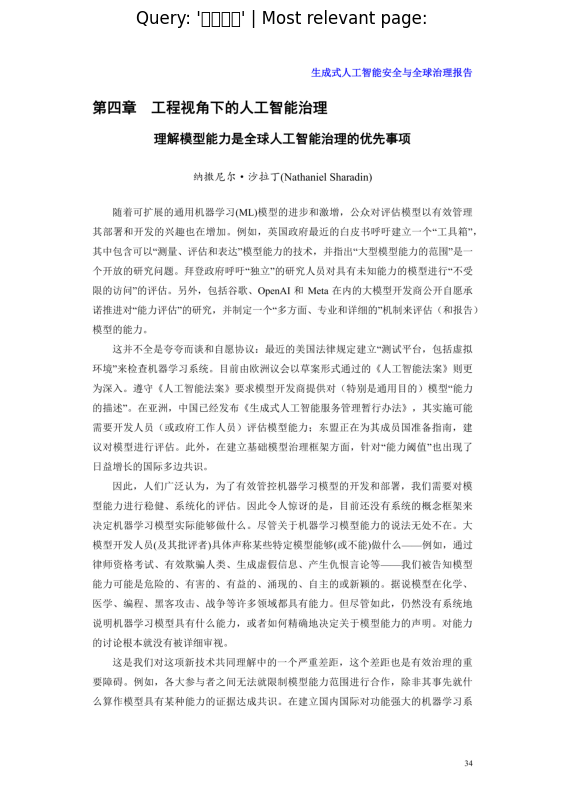

In [44]:
import fitz

# Open PDF and load target page
#pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
pdf_path = "ai.pdf"
doc = fitz.open(pdf_path)
#page = doc.load_page(5 + 41) # number of page (our doc starts page numbers on page 41)
page = doc.load_page(5 + 40)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

Nice!

Now we can do extra research if we'd like.

We could repeat this workflow for any kind of query we'd like on our textbook.

And it would also work for other datatypes too.

We could use semantic search on customer support documents.

Or email threads.

Or company plans.

Or our old journal entries.

Almost anything!

The workflow is the same:

`ingest documents -> split into chunks -> embed chunks -> make a query -> embed the query -> compare query embedding to chunk embeddings`

And we get relevant resources *along with* the source they came from!

That's the **retrieval** part of Retrieval Augmented Generation (RAG).

Before we get to the next two steps, let's take a small aside and discuss similarity measures.

### Similarity measures: dot product and cosine similarity

Let's talk similarity measures between vectors.

Specifically, embedding vectors which are representations of data with magnitude and direction in high dimensional space (our embedding vectors have 768 dimensions).

Two of the most common you'll across are the dot product and cosine similarity.

They are quite similar.

The main difference is that cosine similarity has a normalization step.

| Similarity measure | Description | Code |
| ----- | ----- | ----- |
| [Dot Product](https://en.wikipedia.org/wiki/Dot_product) | - Measure of magnitude and direction between two vectors<br>- Vectors that are aligned in direction and magnitude have a higher positive value<br>- Vectors that are opposite in direction and magnitude have a higher negative value | [`torch.dot`](https://pytorch.org/docs/stable/generated/torch.dot.html), [`np.dot`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html), [`sentence_transformers.util.dot_score`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.dot_score) |
| [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) | - Vectors get normalized by magnitude/[Euclidean norm](https://en.wikipedia.org/wiki/Norm_(mathematics))/L2 norm so they have unit length and are compared more so on direction<br>- Vectors that are aligned in direction have a value close to 1<br>- Vectors that are opposite in direction have a value close to -1 | [`torch.nn.functional.cosine_similarity`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html), [`1 - scipy.spatial.distance.cosine`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html) (subtract the distance from 1 for similarity measure), [`sentence_transformers.util.cos_sim`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.cos_sim) |

For text similarity, you generally want to use cosine similarity as you are after the semantic measurements (direction) rather than magnitude.

In our case, our embedding model `all-mpnet-base-v2` outputs normalized outputs (see the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#usage-huggingface-transformers) for more on this) so dot product and cosine similarity return the same results. However, dot product is faster due to not need to perform a normalize step.

To make things bit more concrete, let's make simple dot product and cosine similarity functions and view their results on different vectors.

> **Note:** Similarity measures between vectors and embeddings can be used on any kind of embeddings, not just text embeddings. For example, you could measure image embedding similarity or audio embedding similarity. Or with text and image models like [CLIP](https://github.com/mlfoundations/open_clip), you can measure the similarity between text and image embeddings.

In [45]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


Notice for both dot product and cosine similarity the comparisons of `vector1` and `vector2` are the opposite of `vector1` and `vector4`.

Comparing `vector1` and `vector2` both equations return positive values (14 for dot product and 1.0 for cosine similarity).

But comparing `vector1` and `vector4` the result is in the negative direction.

This makes sense because `vector4` is the negative version of `vector1`.

Whereas comparing `vector1` and `vector3` shows a different outcome.

For the dot product, the value is positive and larger then the comparison of two exactly the same vectors (32 vs 14).

However, for the cosine similarity, thanks to the normalization step, comparing `vector1` and `vector3` results in a postive value close to 1 but not exactly 1.

It is because of this that when comparing text embeddings, cosine similarity is generally favoured as it measures the difference in direction of a pair of vectors rather than difference in magnitude.

And it is this difference in direction that is more generally considered to capture the semantic meaning/vibe of the text.

The good news is that as mentioned before, the outputs of our embedding model `all-mpnet-base-v2` are already normalized.

So we can continue using the dot product (cosine similarity is dot product + normalization).

With similarity measures explained, let's functionize our semantic search steps from above so we can repeat them.

### Functionizing our semantic search pipeline

Let's put all of the steps from above for semantic search into a function or two so we can repeat the workflow.

In [46]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

Excellent! Now let's test our functions out.

In [71]:
query = "ChatGPT"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 101 embeddings: 0.00008 seconds.


(tensor([0.3181, 0.1889, 0.1848, 0.1710, 0.1679], device='cuda:0'),
 tensor([87, 13,  2, 71, 14], device='cuda:0'))

In [72]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 101 embeddings: 0.00008 seconds.
Query: ChatGPT

Results:
Score: 0.3181
第四章 工程视角下的人工智能治理 47 多元、开放、互动：生成式人工智能模型训练所需的原则 刘纪璐(JeeLooLiu)
生成性人工智能模型是在由书籍、文章、在线资源和其他可用数据组成的广泛数据集上训练的。大语言模型训练的优势在于其能够训练AI直接从自然语言处理信息， 并生成语法和
风格上出色的内容。迄今为止最成功的模型ChatGPT-
4，已经展示了在处理广泛主题信息方面的极速性能。尽管它被批评为制造了许多事实错误，但这些错误在未来一代生成性人工智能中应该能够避免。
然而，这种机器学习方法也存在紧迫的问题，正如ChatGPT等模型的表现所证明的那样： 1.训练基于现有数据，因此结果不反映任何新发展的情况或新的输入。正如休谟所
指出的：没有保证未来会像过去一样。现有方法有忽视未来例子的风险，并延续当前社会中存在的偏见、不公正和错误歧视。2.书籍和文章中的现有文本只包括那些电子可获取的项
目。因此，结果将始终排除古老的非数字化文本和来自不发达国家或边缘化文化的非数字化文本。我们因此忽略了非数字化文本中代表的宝贵观点，忽视了对全面人类知识库至关重要
的输入。3.
Page number: 18


Score: 0.1889
第一章 生成式人工智能的风险与挑战 1 第一章 生成式人工智能的风险与挑战 大语言模型怪兽对利维坦与法律秩序的挑战 季卫东 自2017年谷歌发布Transfor
mer网络架构以来，短短五年多的时间，世界上迅速出现了一大群大模型，而这些模型又衍生出多种技术架构、多种模态、多种场景。从已发布大模型的全球分布来看，中国和美国
明显领先，超过全球总量的80%，其中美国的大模型数量一直位居全球第一。 ChatGPT于2022年11月底一经发布，就凭借强大的对话能力和广泛的应用风靡全球，短
短两个月的时间就让月活跃用户规模达到1亿，增速极其可观。此后，这些大型语言模型相继发布，从赋能个人、减轻企业负担等方面深刻影响了包括法律运作在内的各种社会实践场
景，留下了一幅生成式AI物种大爆发的数字“寒武纪”景观。据不完全统计，截至2023年5月，中国科技企

### Semantic search/vector search extensions

We've covered an exmaple of using embedding vector search to find relevant results based on a query.

However, you could also add to this pipeline with traditional keyword search.

Many modern search systems use keyword and vector search in tandem.

Our dataset is small and allows for an exhaustive search (comparing the query to *every* possible result) but if you start to work with large scale datasets with hundred of thousands, millions or even billions of vectors, you'll want to implement an index.

You can think of an index as sorting your embeddings before you search through them.

So it narrows down the search space.

For example, it would be inefficient to search every word in the dictionary to find the word "duck", instead you'd go straight to the letter D, perhaps even straight to the back half of the letter D, find words close to "duck" before finding it.

That's how an index can help search through many examples without comprimising too much on speed or quality (for more on this, check out [nearest neighbour search](https://en.wikipedia.org/wiki/Nearest_neighbor_search)).

One of the most popular indexing libraries is [Faiss](https://github.com/facebookresearch/faiss).

Faiss is open-source and was originally created by Facebook to deal with internet-scale vectors and implements many algorithms such as [HNSW](https://arxiv.org/abs/1603.09320) (Hierarchical Naviganle Small Worlds).

### Getting an LLM for local generation

We're got our retrieval pipeline ready, let's now get the generation side of things happening.

To perform generation, we're going to use a Large Language Model (LLM).

LLMs are designed to generate an output given an input.

In our case, we want our LLM to generate and output of text given a input of text.

And more specifically, we want the output of text to be generated based on the context of relevant information to the query.

The input to an LLM is often referred to as a prompt.

We'll augment our prompt with a query as well as context from our textbook related to that query.

> **Which LLM should I use?**

There are many LLMs available.

Two of the main questions to ask from this is:
1. Do I want it to run locally?
2. If yes, how much compute power can I dedicate?

If you're after the absolute best performance, you'll likely want to use an API (not running locally) such as GPT-4 or Claude 3. However, this comes with the tradeoff of sending your data away and then awaiting a response.

For our case, since we want to set up a local pipeline and run it on our own GPU, we'd answer "yes" to the first question and then the second question will depend on what hardware we have available.

To find open-source LLMs, one great resource is the [Hugging Face open LLM leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard).

The leaderboard compares many of the latest and greatest LLMs on various benchmarks.

Another great resource is [TheBloke on Hugging Face](https://huggingface.co/TheBloke), an account which provides an extensive range of quantized (models that have been made smaller) LLMs.

A rule of thumb for LLMs (and deep learning models in general) is that the higher the number of parameters, the better the model performs.

It may be tempting to go for the largest size model (e.g. a 70B parameter model rather than a 7B parameter model) but a larger size model may not be able to run on your available hardware.

The following table gives an insight into how much GPU memory you'll need to load an LLM with different sizes and different levels of [numerical precision](https://en.wikipedia.org/wiki/Precision_(computer_science)).

They are based on the fact that 1 float32 value (e.g. `0.69420`) requires 4 bytes of memory and 1GB is approximately 1,000,000,000 (one billion) bytes.

| Model Size (Billion Parameters) | Float32 VRAM (GB) | Float16 VRAM (GB) | 8-bit VRAM (GB) | 4-bit VRAM (GB) |
|-----|-----|-----|-----|-----|
| 1B                              | ~4                | ~2                | ~1              | ~0.5            |
| 7B (e.g., [Llama 2 7B](https://huggingface.co/meta-llama/Llama-2-7b), [Gemma 7B](https://huggingface.co/google/gemma-7b-it), [Mistral 7B](https://huggingface.co/mistralai/Mistral-7B-v0.1))             | ~28               | ~14               | ~7              | ~3.5            |
| 10B                             | ~40               | ~20               | ~10             | ~5              |
| 70B (e.g, Llama 2 70B)          | ~280              | ~140              | ~70             | ~35             |
| 100B                            | ~400              | ~200              | ~100            | ~50             |
| 175B                            | ~700              | ~350              | ~175            | ~87.5           |

<br>

> **Note:** Loading a model in a lower precision (e.g. 8-bit instead of float16) generally lowers performance. Lower precision can help to reduce computing requirements, however sometimes the performance degradation in terms of model output can be substantial. Finding the right speed/performance tradeoff will often require many experiments.

### Checking local GPU memory availability

Let's find out what hardware we've got available and see what kind of model(s) we'll be able to load.

> **Note:** You can also check this with the `!nvidia-smi` command.

In [73]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


Ok wonderful!

I'm running this notebook with a NVIDIA RTX 4090, so I've got 24GB of VRAM available.

However, this may be different on your end.

Looking at the table above, it seems we can run a ~7-10B parameter model in float16 precision pretty comfortably.

But we could also run a smaller one if we'd like.

Let's try out the recently released (at the time of writing, March 2024) LLM from Google, [Gemma](https://huggingface.co/blog/gemma).

Specifically, we'll use the `gemma-7b-it` version which stands for Gemma 7B Instruction-Tuned.

Instruction tuning is the process of tuning a raw language model to follow instructions.

These are the kind of models you'll find in most chat-based assistants such as ChatGPT, Gemini or Claude.

The following table shows different amounts of GPU memory requirements for different verions of the Gemma LLMs with varying levels of precision.

| Model             | Precision | Min-Memory (Bytes) | Min-Memory (MB) | Min-Memory (GB) | Recommended Memory (GB) | Hugging Face ID |
|-------------------|-----------|----------------|-------------|-------------| ----- | ----- |
| [Gemma 2B](https://huggingface.co/google/gemma-2b-it)          | 4-bit     | 2,106,749,952  | 2009.15     | 1.96        | ~5.0 | [`gemma-2b`](https://huggingface.co/google/gemma-2b) or [`gemma-2b-it`](https://huggingface.co/google/gemma-2b-it) for instruction tuned version |
| Gemma 2B          | Float16   | 5,079,453,696  | 4844.14     | 4.73        | ~8.0 | Same as above |
| [Gemma 7B](https://huggingface.co/google/gemma-7b-it)          | 4-bit     | 5,515,859,968  | 5260.33     | 5.14        | ~8.0 | [`gemma-7b`](https://huggingface.co/google/gemma-7b) or [`gemma-7b-it`](https://huggingface.co/google/gemma-7b-it) for instruction tuned version |
| Gemma 7B          | Float16   | 17,142,470,656 | 16348.33    | 15.97       | ~19 | Same as above |

> **Note:** `gemma-7b-it` means "instruction tuned", as in, a base LLM (`gemma-7b`) has been fine-tuned to follow instructions, similar to [`Mistral-7B-v0.1`](https://huggingface.co/mistralai/Mistral-7B-v0.1) and [`Mistral-7B-Instruct-v0.1`](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1).
>
> There are also further quantized and smaller variants of Gemma (and other LLMs) available in various formats such as GGUF. You can see many of these on [TheBloke account on Hugging Face](https://huggingface.co/TheBloke).
>
> The version of LLM you choose to use will be largely based on project requirements and experimentation.

Based on the table above, let's write a simple if/else statement which recommends which Gemma variant we should look into using.

In [74]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


### Loading an LLM locally

Alright! Looks like `gemma-7b-it` it is (for my local machine with an RTX 4090, change the `model_id` and `use_quantization_config` values to suit your needs)!

There are plenty of examples of how to load the model on the `gemma-7b-it` [Hugging Face model card](https://huggingface.co/google/gemma-7b-it).

Good news is, the Hugging Face [`transformers`](https://huggingface.co/docs/transformers/) library has all the tools we need.

To load our LLM, we're going to need a few things:
1. A quantization config (optional) - This will determine whether or not we load the model in 4bit precision for lower memory usage. The we can create this with the [`transformers.BitsAndBytesConfig`](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/quantization#transformers.BitsAndBytesConfig) class (requires installing the [`bitsandbytes` library](https://github.com/TimDettmers/bitsandbytes)).
2. A model ID - This is the reference Hugging Face model ID which will determine which tokenizer and model gets used. For example `gemma-7b-it`.
3. A tokenzier - This is what will turn our raw text into tokens ready for the model. We can create it using the [`transformers.AutoTokenzier.from_pretrained`](https://huggingface.co/docs/transformers/v4.38.2/en/model_doc/auto#transformers.AutoTokenizer) method and passing it our model ID.
4. An LLM model - Again, using our model ID we can load a specific LLM model. To do so we can use the [`transformers.AutoModelForCausalLM.from_pretrained`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForCausalLM.from_pretrained) method and passing it our model ID as well as other various parameters.

As a bonus, we'll check if [Flash Attention 2](https://huggingface.co/docs/transformers/perf_infer_gpu_one#flashattention-2) is available using `transformers.utils.is_flash_attn_2_available()`. Flash Attention 2 speeds up the attention mechanism in Transformer architecture models (which is what many modern LLMs are based on, including Gemma). So if it's available and the model is supported (not all models support Flash Attention 2), we'll use it. If it's not available, you can install it by following the instructions on the [GitHub repo](https://github.com/Dao-AILab/flash-attention).

> **Note:** Flash Attention 2 currently works on NVIDIA GPUs with a compute capability score of 8.0+ (Ampere, Ada Lovelace, Hopper architectures). We can check our GPU compute capability score with [`torch.cuda.get_device_capability(0)`](https://pytorch.org/docs/stable/generated/torch.cuda.get_device_capability.html).

> **Note:** To get access to the Gemma models, you will have to [agree to the terms & conditions](https://huggingface.co/google/gemma-7b-it) on the Gemma model page on Hugging Face. You will then have to authorize your local machine via the [Hugging Face CLI/Hugging Face Hub `login()` function](https://huggingface.co/docs/huggingface_hub/en/quick-start#authentication). Once you've done this, you'll be able to download the models. If you're using Google Colab, you can add a [Hugging Face token](https://huggingface.co/docs/hub/en/security-tokens) to the "Secrets" tab.
>
> Downloading an LLM locally can take a fair bit of time depending on your internet connection. Gemma 7B is about a 16GB download and Gemma 2B is about a 6GB download.

Let's do it!

In [77]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = "microsoft/Phi-3.5-mini-instruct"
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: microsoft/Phi-3.5-mini-instruct


tokenizer_config.json:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

We've got an LLM!

Let's check it out.

In [78]:
llm_model

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3SdpaAttention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3LongRoPEScaledRotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): Phi3RMSNorm((3072,)

Ok, ok a bunch of layers ranging from embedding layers to attention layers (see the `GemmaFlashAttention2` layers!) to MLP and normalization layers.

The good news is that we don't have to know too much about these to use the model.

How about we get the number of parameters in our model?

In [79]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

3821079552

Hmm, turns out that Gemma 7B is really Gemma 8.5B.

It pays to do your own investigations!

How about we get the models memory requirements?

In [80]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 7642165248, 'model_mem_mb': 7288.14, 'model_mem_gb': 7.12}

Nice, looks like this model takes up 15.97GB of space on the GPU.

Plus a little more for the forward pass (due to all the calculations happening between the layers).

Hence why I rounded it up to be ~19GB in the table above.

Now let's get to the fun part, generating some text!

### Generating text with our LLM

We can generate text with our LLM `model` instance by calling the [`generate()` method](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig) (this method has plenty of options to pass into it alongside the text) on it and passing it a tokenized input.

The tokenized input comes from passing a string of text to our `tokenizer`.

It's important to note that you should use a tokenizer that has been paired with a model.

Otherwise if you try to use a different tokenizer and then pass those inputs to a model, you will likely get errors/strange results.

For some LLMs, there's a specific template you should pass to them for ideal outputs.

For example, the `gemma-7b-it` model has been trained in a dialogue fashion (instruction tuning).

In this case, our `tokenizer` has a [`apply_chat_template()` method](https://huggingface.co/docs/transformers/main/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.apply_chat_template) which can prepare our input text in the right format for the model.

Let's try it out.

> **Note:** The following demo has been modified from the Hugging Face model card for [Gemma 7B](https://huggingface.co/google/gemma-7b-it). Many similar demos of usage are available on the model cards of similar models.

In [81]:
#input_text = "What are the macronutrients, and what roles do they play in the human body?"
input_text = "英特尔如何进行负责任的人工智能应用探索？"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
英特尔如何进行负责任的人工智能应用探索？

Prompt (formatted):
<|user|>
英特尔如何进行负责任的人工智能应用探索？<|end|>
<|assistant|>



Notice the scaffolding around our input text, this is the kind of turn-by-turn instruction tuning our model has gone through.

Our next step is to tokenize this formatted text and pass it to our model's `generate()` method.

We'll make sure our tokenized text is on the same device as our model (GPU) using `to("cuda")`.

Let's generate some text!

We'll time it for fun with the `%%time` magic.

In [85]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=1000) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[32010, 29871, 31144, 31141, 31814, 30847, 31502, 31174, 30448,   235,
           183,   162,   235,   183,   166, 31450, 30210, 30313, 31041, 31676,
         30815, 31370, 30406,   233,   145,   165, 31836, 30882, 32007, 32001]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]], device='cuda:0')}

Model output (tokens):
tensor([32010, 29871, 31144,  ...,   178, 30503, 30564], device='cuda:0')

CPU times: user 1min 5s, sys: 0 ns, total: 1min 5s
Wall time: 1min 6s


Woohoo! We just generated some text on our local GPU!

Well not just yet...

Our LLM accepts tokens in and sends tokens back out.

We can conver the output tokens to text using [`tokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode).

In [86]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<|user|> 英特尔如何进行负责任的人工智能应用探索？<|end|><|assistant|> 英特尔在负责任的人工智能（AI）应用探索方面采取了多项策略，以确保其技术的可靠性、伦理性和社会影响。以下是英特尔在这方面的一些关键方面：

1. 伦理AI指南：英特尔推出了一个全面的伦理AI指南，旨在指导其员工在开发和应用AI时考虑伦理问题。这些指南涵盖了公平性、透明度、责任和隐私等关键方面。

2. 公平和包容性：英特尔专注于确保其AI系统不受偏见影响，并且在各种群体中表现出平等性。他们通过使用多样化的数据集、评估算法和监督来实现这一目标。

3. 隐私和数据保护：英特尔强调了数据隐私和安全性的重要性，并通过实施先进的数据加密和安全措施来保护用户数据。他们还支持数据保护法规，如欧洲的《通用数据保护条例》（GDPR）。

4. 合作伙伴关系：英特尔与多家行业领先企业、学术机构和非营利组织合作，共同推动负责任的AI发展。这些合作伙伴关系帮助他们探索新的应用和解决方案，同时确保伦理标准。

5. 研究和发展：英特尔投资于AI研究和开发，专注于解决社会和技术挑战。他们在多个研究机构和实验室中进行研究，包括人工智能、机器学习和计算机视觉等领域。

6. 教育和培训：英特尔认识到了AI专业知识的重要性，因此投资于教育和培训项目。他们提供各种资源，包括在线课程、研讨会和工作坊，以帮助员工和合作伙伴了解AI技术和应用。

7. 社区参与：英特尔鼓励社区参与其AI探索，包括公众、政策制定者和行业专家。他们通过举办活动、发布报告和发表论文，推动对负责任AI的讨论和讨论。

总之，英特尔通过其伦理AI指南、公平性、隐私保护、合作伙伴关系、研究和发展、教育和社区参与等多方面，推动负责任的AI应用探索。通过这些策略，英特尔旨在确保其AI技术对社会有积极的影响，并解决复杂的技术和社



Woah! That looks like a pretty good answer.

But notice how the output contains the prompt text as well?

How about we do a little formatting to replace the prompt in the output text?

> **Note:** `"<bos>"` and `"<eos>"` are special tokens to denote "beginning of sentence" and "end of sentence" respectively.

In [87]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: 英特尔如何进行负责任的人工智能应用探索？

Output text:
<|user|> 英特尔如何进行负责任的人工智能应用探索？<|end|><|assistant|> 英特尔在负责任的人工智能（AI）应用探索方面采取了多项策略，以确保其技术的可靠性、伦理性和社会影响。以下是英特尔在这方面的一些关键方面：

1. 伦理AI指南：英特尔推出了一个全面的伦理AI指南，旨在指导其员工在开发和应用AI时考虑伦理问题。这些指南涵盖了公平性、透明度、责任和隐私等关键方面。

2. 公平和包容性：英特尔专注于确保其AI系统不受偏见影响，并且在各种群体中表现出平等性。他们通过使用多样化的数据集、评估算法和监督来实现这一目标。

3. 隐私和数据保护：英特尔强调了数据隐私和安全性的重要性，并通过实施先进的数据加密和安全措施来保护用户数据。他们还支持数据保护法规，如欧洲的《通用数据保护条例》（GDPR）。

4. 合作伙伴关系：英特尔与多家行业领先企业、学术机构和非营利组织合作，共同推动负责任的AI发展。这些合作伙伴关系帮助他们探索新的应用和解决方案，同时确保伦理标准。

5. 研究和发展：英特尔投资于AI研究和开发，专注于解决社会和技术挑战。他们在多个研究机构和实验室中进行研究，包括人工智能、机器学习和计算机视觉等领域。

6. 教育和培训：英特尔认识到了AI专业知识的重要性，因此投资于教育和培训项目。他们提供各种资源，包括在线课程、研讨会和工作坊，以帮助员工和合作伙伴了解AI技术和应用。

7. 社区参与：英特尔鼓励社区参与其AI探索，包括公众、政策制定者和行业专家。他们通过举办活动、发布报告和发表论文，推动对负责任AI的讨论和讨论。

总之，英特尔通过其伦理AI指南、公平性、隐私保护、合作伙伴关系、研究和发展、教育和社区参与等多方面，推动负责任的AI应用探索。通过这些策略，英特尔旨在确保其AI技术对社会有积极的影响，并解决复杂的技术和社


How cool is that!

We just officially generated text from an LLM running locally.

So we've covered the R (retrieval) and G (generation) of RAG.

How about we check out the last step?

Augmentation.

First, let's put together a list of queries we can try out with our pipeline.

In [88]:
# Nutrition-style questions generated with GPT4
#gpt4_questions = [
    #"What are the macronutrients, and what roles do they play in the human body?",
    #"How do vitamins and minerals differ in their roles and importance for health?",
    #"Describe the process of digestion and absorption of nutrients in the human body.",
    #"What role does fibre play in digestion? Name five fibre containing foods.",
    #"Explain the concept of energy balance and its importance in weight management."
#]

gpt4_questions = [
    "生成性人工智能在安全方面存在哪些潜在风险?",

    "各国在生成性人工智能的治理中面临哪些挑战与机遇？",

    "如何建立有效的国际合作机制，以确保生成性人工智能的安全使用？",

    "生成性人工智能的伦理问题如何影响其全球治理框架的制定？",

    "在生成性人工智能的发展过程中，如何平衡创新与安全之间的关系？"
]

# Manually created question list
#manual_questions = [
    #"How often should infants be breastfed?",
    #"What are symptoms of pellagra?",
    #"How does saliva help with digestion?",
    #"What is the RDI for protein per day?",
    #"water soluble vitamins"
#]

manual_questions = [
    "生成性人工智能的安全重要吗？",
    "什么是生成性人工智能的全球治理？",
    "生成式人工智能的发展趋势是什么？",
    "有哪些关于人工智能的规定？",
    "应该限制人工智能吗？"
]

query_list = gpt4_questions + manual_questions

And now let's check if our `retrieve_relevant_resources()` function works with our list of queries.

In [89]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: 各国在生成性人工智能的治理中面临哪些挑战与机遇？
[INFO] Time taken to get scores on 101 embeddings: 0.00007 seconds.


(tensor([0.7412, 0.7392, 0.7368, 0.7289, 0.7269], device='cuda:0'),
 tensor([61, 18, 52, 26, 55], device='cuda:0'))

Beautiful!

Let's augment!

### Augmenting our prompt with context items

What we'd like to do with augmentation is take the results from our search for relevant resources and put them into the prompt that we pass to our LLM.

In essence, we start with a base prompt and update it with context text.

Let's write a function called `prompt_formatter` that takes in a query and our list of context items (in our case it'll be select indices from our list of dictionaries inside `pages_and_chunks`) and then formats the query with text from the context items.

We'll apply the dialogue and chat template to our prompt before returning it as well.

> **Note:** The process of augmenting or changing a prompt to an LLM is known as prompt engineering. And the best way to do it is an active area of research. For a comprehensive guide on different prompt engineering techniques, I'd recommend the Prompt Engineering Guide ([promptingguide.ai](https://www.promptingguide.ai/)), [Brex's Prompt Engineering Guide](https://github.com/brexhq/prompt-engineering) and the paper [Prompt Design and Engineering: Introduction and Advanced Models](https://arxiv.org/abs/2401.14423).

In [90]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """根据以下上下文内容，请回答查询。
请提取相关段落以帮助思考，然后再回答查询。
不要返回思考过程，只返回答案。
确保你的回答尽可能详尽。
使用以下示例作为理想答案风格的参考。

\n示例 1:
查询：生成性人工智能的主要安全风险有哪些？
答案：生成性人工智能的主要安全风险包括数据隐私泄露、生成虚假信息和模型滥用等。数据隐私泄露可能导致用户敏感信息被不当使用，影响个人隐私和安全。生成虚假信息则可能被用于传播谣言或误导公众，影响社会信任与安全。此外，模型滥用可能使恶意用户利用生成性人工智能进行网络攻击或其他非法活动，进一步加剧安全隐患。

\n示例 2:
查询：全球治理生成性人工智能的挑战是什么？
答案：全球治理生成性人工智能面临多重挑战，包括法律法规的不统一、技术快速发展与监管滞后之间的矛盾，以及各国在伦理标准上的差异。不同国家对人工智能的监管政策和法律框架各不相同，导致跨国合作困难。此外，技术的迅速演变使得现有的监管机制往往无法及时适应新出现的风险和问题，增加了全球治理的复杂性。

\n示例 3:
查询：如何确保生成性人工智能的安全使用？
答案：确保生成性人工智能的安全使用需要建立健全的法律法规框架，促进国际合作与信息共享。首先，各国应制定明确的人工智能伦理标准和使用规范，以防止技术滥用。其次，建立国际合作机制，分享最佳实践和经验，以应对跨国性问题。此外，开展公众教育和培训，提高用户对生成性人工智能潜在风险的认识，也是确保其安全使用的重要措施。

\n现在使用以下上下文内容回答用户查询：
{context}
\n相关段落：<从上下文中提取相关段落>
用户查询：{query}
答案："""



    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

Looking good! Let's try our function out.

In [91]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: 生成性人工智能在安全方面存在哪些潜在风险?
[INFO] Time taken to get scores on 101 embeddings: 0.00006 seconds.
<|user|>
根据以下上下文内容，请回答查询。
请提取相关段落以帮助思考，然后再回答查询。
不要返回思考过程，只返回答案。
确保你的回答尽可能详尽。
使用以下示例作为理想答案风格的参考。


示例 1:
查询：生成性人工智能的主要安全风险有哪些？
答案：生成性人工智能的主要安全风险包括数据隐私泄露、生成虚假信息和模型滥用等。数据隐私泄露可能导致用户敏感信息被不当使用，影响个人隐私和安全。生成虚假信息则可能被用于传播谣言或误导公众，影响社会信任与安全。此外，模型滥用可能使恶意用户利用生成性人工智能进行网络攻击或其他非法活动，进一步加剧安全隐患。


示例 2:
查询：全球治理生成性人工智能的挑战是什么？
答案：全球治理生成性人工智能面临多重挑战，包括法律法规的不统一、技术快速发展与监管滞后之间的矛盾，以及各国在伦理标准上的差异。不同国家对人工智能的监管政策和法律框架各不相同，导致跨国合作困难。此外，技术的迅速演变使得现有的监管机制往往无法及时适应新出现的风险和问题，增加了全球治理的复杂性。


示例 3:
查询：如何确保生成性人工智能的安全使用？
答案：确保生成性人工智能的安全使用需要建立健全的法律法规框架，促进国际合作与信息共享。首先，各国应制定明确的人工智能伦理标准和使用规范，以防止技术滥用。其次，建立国际合作机制，分享最佳实践和经验，以应对跨国性问题。此外，开展公众教育和培训，提高用户对生成性人工智能潜在风险的认识，也是确保其安全使用的重要措施。


现在使用以下上下文内容回答用户查询：
- 生成式人工智能安全与全球治理报告 4 以更积极主动的治理应对人工智能发展中的风险与挑战 段伟文 近年来，人工智能在认知、决策、知识生产和智能代理等方面日益显现出超强能力，这使得人工智能成为各国科技领域的优先发展事项。但也因为其发展所凸显的危害、风险和争议，而促使各国和全世界全面展开了人工智能治理。 人工智能治理主要针对两个方面的问题：一是由于人工智能发展的价值和目标不明确，以及恶意使用和滥用，使其给人类、个人、社会、环境和生态系统造成了现实的危害和潜在的风险，其中包括对隐私和数据

What a good looking prompt!

We can tokenize this and pass it straight to our LLM.

In [92]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: 生成性人工智能在安全方面存在哪些潜在风险?
RAG answer:
<|user|> 根据以下上下文内容，请回答查询。
请提取相关段落以帮助思考，然后再回答查询。
不要返回思考过程，只返回答案。
确保你的回答尽可能详尽。
使用以下示例作为理想答案风格的参考。


示例 1:
查询：生成性人工智能的主要安全风险有哪些？
答案：生成性人工智能的主要安全风险包括数据隐私泄露、生成虚假信息和模型滥用等。数据隐私泄露可能导致用户敏感信息被不当使用，影响个人隐私和安全。生成虚假信息则可能被用于传播谣言或误导公众，影响社会信任与安全。此外，模型滥用可能使恶意用户利用生成性人工智能进行网络攻击或其他非法活动，进一步加剧安全隐患。


示例 2:
查询：全球治理生成性人工智能的挑战是什么？
答案：全球治理生成性人工智能面临多重挑战，包括法律法规的不统一、技术快速发展与监管滞后之间的矛盾，以及各国在伦理标准上的差异。不同国家对人工智能的监管政策和法律框架各不相同，导致跨国合作困难。此外，技术的迅速演变使得现有的监管机制往往无法及时适应新出现的风险和问题，增加了全球治理的复杂性。


示例 3:
查询：如何确保生成性人工智能的安全使用？
答案：确保生成性人工智能的安全使用需要建立健全的法律法规框架，促进国际合作与信息共享。首先，各国应制定明确的人工智能伦理标准和使用规范，以防止技术滥用。其次，建立国际合作机制，分享最佳实践和经验，以应对跨国性问题。此外，开展公众教育和培训，提高用户对生成性人工智能潜在风险的认识，也是确保其安全使用的重要措施。


现在使用以下上下文内容回答用户查询：
- 生成式人工智能安全与全球治理报告 4 以更积极主动的治理应对人工智能发展中的风险与挑战 段伟文 近年来，人工智能在认知、决策、知识生产和智能代理等方面日益显现出超强能力，这使得人工智能成为各国科技领域的优先发展事项。但也因为其发展所凸显的危害、风险和争议，而促使各国和全世界全面展开了人工智能治理。 人工智能治理主要针对两个方面的问题：一是由于人工智能发展的价值和目标不明确，以及恶意使用和滥用，使其给人类、个人、社会、环境和生态系统造成了现实的危害和潜在的风险，其中包括对隐私和数据权侵害、偏见和歧视的加剧等。二是因人工智能发展的不平衡以及受益与风险分配的不公，带来了 “谁受益？谁付出？谁承担

Yesssssss!!!

Our RAG pipeline is complete!

We just Retrieved, Augmented and Generated!

And all on our own local GPU!

How about we functionize the generation step to make it easier to use?

We can put a little formatting on the text being returned to make it look nice too.

And we'll make an option to return the context items if needed as well.

In [93]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

What a good looking function!

The workflow could probably be a little refined but this should work!

Let's try it out.

In [94]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: 生成性人工智能的安全重要吗？
[INFO] Time taken to get scores on 101 embeddings: 0.00007 seconds.
Answer:

<|user|> 根据以下上下文内容，请回答查询。 请提取相关段落以帮助思考，然后再回答查询。 不要返回思考过程，只返回答案。 确保你的回答尽可能详尽。
使用以下示例作为理想答案风格的参考。   示例 1: 查询：生成性人工智能的主要安全风险有哪些？ 答案：生成性人工智能的主要安全风险包括数据隐私泄露、生成虚假信
息和模型滥用等。数据隐私泄露可能导致用户敏感信息被不当使用，影响个人隐私和安全。生成虚假信息则可能被用于传播谣言或误导公众，影响社会信任与安全。此外，模型滥用可
能使恶意用户利用生成性人工智能进行网络攻击或其他非法活动，进一步加剧安全隐患。   示例 2: 查询：全球治理生成性人工智能的挑战是什么？ 答案：全球治理生成性
人工智能面临多重挑战，包括法律法规的不统一、技术快速发展与监管滞后之间的矛盾，以及各国在伦理标准上的差异。不同国家对人工智能的监管政策和法律框架各不相同，导致跨
国合作困难。此外，技术的迅速演变使得现有的监管机制往往无法及时适应新出现的风险和问题，增加了全球治理的复杂性。   示例 3:
查询：如何确保生成性人工智能的安全使用？ 答案：确保生成性人工智能的安全使用需要建立健全的法律法规框架，促进国际合作与信息共享。首先，各国应制定明确的人工智能伦
理标准和使用规范，以防止技术滥用。其次，建立国际合作机制，分享最佳实践和经验，以应对跨国性问题。此外，开展公众教育和培训，提高用户对生成性人工智能潜在风险的认识
，也是确保其安全使用的重要措施。   现在使用以下上下文内容回答用户查询： - 生成式人工智能安全与全球治理报告 4
以更积极主动的治理应对人工智能发展中的风险与挑战 段伟文 近年来，人工智能在认知、决策、知识生产和智能代理等方面日益显现出超强能力，这使得人工智能成为各国科技领
域的优先发展事项。但也因为其发展所凸显的危害、风险和争议，而促使各国和全世界全面展开了人工智能治理。 人工智能治理主要针对两个方面的问题：一是由于人工智能发展的
价值和目标不明确，以及恶意使用和滥用，使其给人类、个人、社会、环境和生态系统造成了现实的危害和潜在的风险，

[{'page_number': -25,
  'sentence_chunk': '生成式人工智能安全与全球治理报告 4 以更积极主动的治理应对人工智能发展中的风险与挑战 段伟文 近年来，人工智能在认知、决策、知识生产和智能代理等方面日益显现出超强能力，这使得人工智能成为各国科技领域的优先发展事项。但也因为其发展所凸显的危害、风险和争议，而促使各国和全世界全面展开了人工智能治理。 人工智能治理主要针对两个方面的问题：一是由于人工智能发展的价值和目标不明确，以及恶意使用和滥用，使其给人类、个人、社会、环境和生态系统造成了现实的危害和潜在的风险，其中包括对隐私和数据权侵害、偏见和歧视的加剧等。二是因人工智能发展的不平衡以及受益与风险分配的不公，带来了 “谁受益？谁付出？谁承担风险？”“谁具有领先优势？谁会被甩在后面？谁处于‘暴露’状态”等社会争议。 从防范风险的视角，目前全球人工智能治理的紧迫事项包括三个方面：一是如何避免有意和无意的人工智能滥用可能导致的重大风险，特别是以往没有关注到的跨领域的复合风险，如随着技术与信息可及性增加和门槛的降低，人工智能与生物技术的非常规结合导致的不可预见的安全风险；二是如何缓解人工智能特别是生成式人工智能对岗位、就业、人才、教育的巨大冲击；三是如何在国际层面形成人工智能军备竞赛的多方管控机制和公开对话渠道。 其中，对于国际社会如何建立有效的风险预警和应对机制并确保在关键时刻人类有能力摁下停止键，这一问题目前没有直接的答案，当可用从以下四个方面作出努力。一是各国和世界要在信息网络系统的安全性方面加强互信与合作，建立起全球风险预警系统；二是各国、不同区域和全球要构建起多个平行的信息网络系统，在有必要的情况下构建人类文明全数据备份时间机器、全球多个信息网络平行运作系统；三是发现和培养可用在人工智能时代具有超强认知、决策能力和未来洞察力的人才，在各国实施超强人才教育培养计划；四是加强人机行为的社会学、人类学、心理学和哲学研究，对此问题展开系统深入的探索。 从促进发展的视角，为了助力世界各国特别是发展中国家的高质量发展和联合国可持续发展目标的落实，人工智能治理要从“被动补偿”和“主动优化”两个方面入手：一是要设法缓解以上两方面的问题，促使人工智能系统在整个生命周期中以负责任和可信任的方式发展；二是应联合国际社会进一步采取一系列主动的预先应对措施

Local RAG workflow complete!

We've now officially got a way to Retrieve, Augment and Generate answers based on a source.

For now we can verify our answers manually by reading them and reading through the textbook.

But if you want to put this into a production system, it'd be a good idea to have some kind of evaluation on how well our pipeline works.

For example, you could use another LLM to rate the answers returned by our LLM and then use those ratings as a proxy evaluation.

However, I'll leave this and a few more interesting ideas as extensions.

## Extensions

* May want to improve text extraction with something like Marker - https://github.com/VikParuchuri/marker
* Guide to more advanced PDF extraction - https://towardsdatascience.com/extracting-text-from-pdf-files-with-python-a-comprehensive-guide-9fc4003d517
* See the following prompt engineering resources for more prompting techniques - promptinguide.ai, Brex's Prompt Engineering Guide
* What happens when a query comes through that there isn't any context in the textbook on?
* Try another embedding model (e.g. Mixed Bread AI large, `mixedbread-ai/mxbai-embed-large-v1`, see: https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)
* Try another LLM... (e.g. Mistral-Instruct)
* Try different prompts (e.g. see prompting techniques online)
* Our example only focuses on text from a PDF, however, we could extend it to include figures and images
* Evaluate the answers -> could use another LLM to rate our answers (e.g. use GPT-4 to make)
* Vector database/index for larger setup (e.g. 100,000+ chunks)
* Libraries/frameworks such as LangChain / LlamaIndex can help do many of the steps for you - so it's worth looking into those next, wanted to recreate a workflow with lower-level tools to show the principles
* Optimizations for speed
    * See Hugging Face docs for recommended speed ups on GPU - https://huggingface.co/docs/transformers/perf_infer_gpu_one
    * Optimum NVIDIA - https://huggingface.co/blog/optimum-nvidia, GitHub: https://github.com/huggingface/optimum-nvidia
    * See NVIDIA TensorRT-LLM - https://github.com/NVIDIA/TensorRT-LLM
    * See GPT-Fast for PyTorch-based optimizations - https://github.com/pytorch-labs/gpt-fast
    * Flash attention 2 (requires Ampere GPUs or newer) - https://github.com/Dao-AILab/flash-attention
* Stream text output so it looks prettier (e.g. each token appears as it gets output from the model)
* Turn the workflow into an app, see Gradio type chatbots for this - https://www.gradio.app/guides/creating-a-chatbot-fast, see local example: https://www.gradio.app/guides/creating-a-chatbot-fast#example-using-a-local-open-source-llm-with-hugging-face